# Scenerio
***
This fraudulent detection system, notebook, will describe a process to identify fraudulent spirit formulas. In this notebook, fraudulent formulas will be compared to valid formulas by describing how closely one formula resembles valid formula in the dataset. 

* First: Construct the dataset
* Second: Plot the data clusters to display the data and to show how fraudulent formulas can be detected

In [1]:
import os
import pandas as pd
import numpy as np
import networkx as nx
from sklearn.datasets import make_blobs
from scipy.spatial.distance import pdist, squareform
import statistics #mean and standard dev measurements
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"]=10,10 #configure plot size

os.chdir(os.environ['MLDIR'] + '/TestData/formula_fraud/data/')

# Dataset Construction
***
After configuring our environment, the data creation process will start by generating clustered formula data. Column names are assigned to several column names which resemble ingredients typically found in spirit formulas. Additionally, columns are assigned for up to 90 additional ingredients that could be present in the formula.

In [2]:
# create column names for dataframe
column_names = []
column_names.append('type')
column_names.append('ethyl')
column_names.append('methonal')
column_names.append('glycerol')
column_names.append('propanol')
column_names.append('coumarin')
column_names.append('citric_acid')
column_names.append('acetaldehyde')
column_names.append('isoamyl_alcohol')
column_names.append('impurities')
for i in range(90):
    column_names.append('add_ingredient'+str(i))

In [3]:
# generate synthetic cluster dataset
X, y = make_blobs(n_samples=100, centers=5, n_features=100, center_box=(1,10), cluster_std=0.5, random_state=4534)

# turn synthetic data into dataframe and assign column names
df = pd.DataFrame(X,columns=column_names)
df['type'] = y

# map cluster labels to spirit names and assign a color palette 
column_mapping = {0:'vodka',1:'rum',2:'whiskey',3:'brandy',4:'gin'}
mkr_dict = {'vodka':'o', 'rum':'o', 'whiskey':'o', 'brandy':'o', 'gin':'o'}
colors = {'vodka':'blue', 'rum':'magenta', 'whiskey':'green', 'brandy':'yellow', 'gin':'brown'}
colors_w = {'wine_1':'blue', 'wine_2':'magenta', 'wine_3':'green', 'brandy':'yellow', 'gin':'brown'}
df.replace({"type": column_mapping},inplace=True)

# Plotting the Data Clusters
***
Clustering N dimensional data is a dimension reduction process. The N dimensions have to be mapped to 2 principal components that are dominant across the N dimensional data set. After the N dimensional data has been mapped to 2 principal components, the data can be represented on a 2-D plot. Clustering was performed on real wine data, and synthetic spirits data. The below plots describe how real wine data clusters, and how possibly the spirit data clusters such that the Euclidean distance, and other higher order statistics can be used to determine how a fraudulent formula resembles a valid formula.

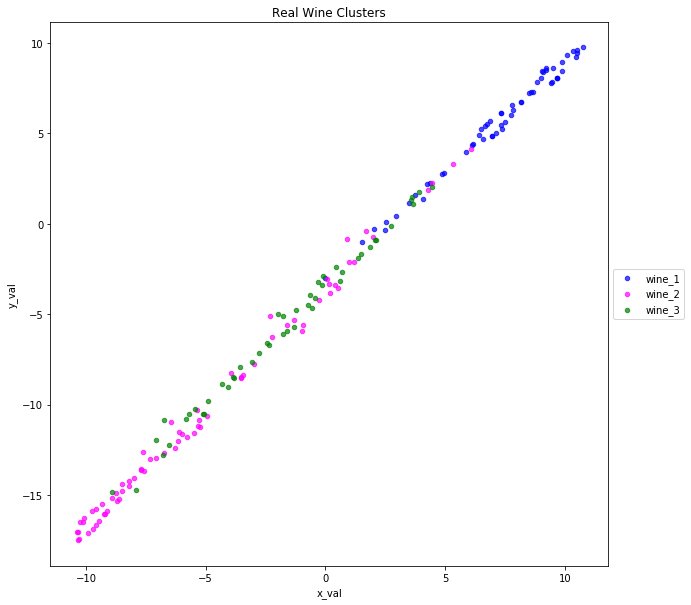

In [4]:
df = pd.read_csv('wine.data.csv')

from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(df)
X_embedded = pd.DataFrame(X_embedded, columns=['x_val', 'y_val'])

X_embedded['type'] = 0
X_embedded['type'] = df.iloc[:,0]
X_embedded.loc[X_embedded['type'] == 1, 'type'] = 'wine_1'
X_embedded.loc[X_embedded['type'] == 2, 'type'] = 'wine_2'
X_embedded.loc[X_embedded['type'] == 3, 'type'] = 'wine_3'

# scatter plot, dots colored by type value
fig, ax = plt.subplots(1,1, figsize=(10, 10))
grouped = X_embedded.groupby('type')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x_val', y='y_val', label=key, color=colors_w[key], alpha=0.7)
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#    plt.axis('off')
plt.title('Real Wine Clusters')
plt.show()

# Fraudulent Data
A fraudulent data point is added under the label 'vodka_fraud.' This particular fraudulent entry is displaying a fraudulent formula of a formula of an existing vodka spirit on the market.

In [5]:
# read fraudulent csv and count the values of the types
fraud_df = pd.read_csv('Synthetic_Formula_Data_Fraud.csv')
display(fraud_df['type'].value_counts().to_frame())

,type
brandy,20
rum,20
gin,20
whiskey,20
vodka,19
vodka_fraud,1


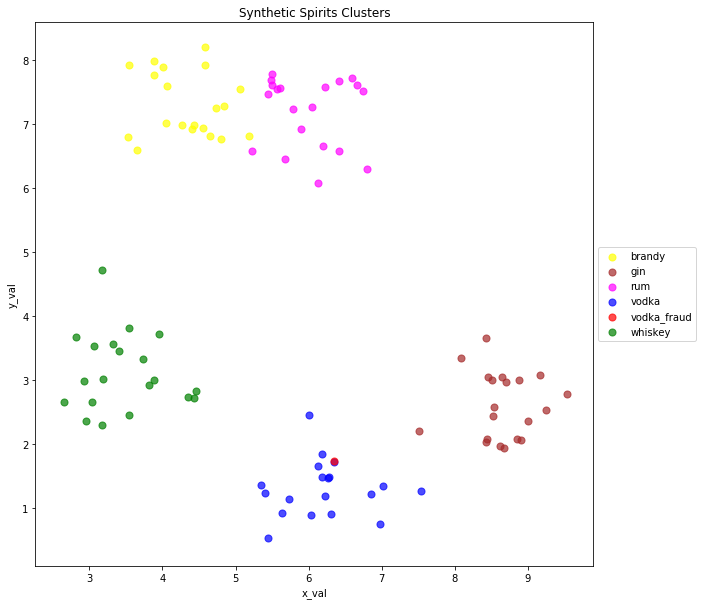

In [6]:
# scatter plot, dots colored by type value
mkr_dict = {'vodka':'o', 'vodka_fraud':'o', 'rum':'o', 'whiskey':'o', 'brandy':'o', 'gin':'o'}
colors = {'vodka':'blue', 'vodka_fraud':'red', 'rum':'magenta', 'whiskey':'green', 'brandy':'yellow', 'gin':'brown'}
fraud_df.rename(columns={"citric_acid": "x_val", "ethyl": "y_val"}, inplace=True)
fig, ax = plt.subplots(1,1, figsize=(10, 10))
grouped = fraud_df.groupby('type')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x_val', y='y_val', label=key, color=colors[key], s=50, alpha=0.7, marker=mkr_dict[key])
    plt.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
#    plt.axis('off')
plt.title('Synthetic Spirits Clusters')
plt.show()